### CaseHOLD error analysis

In this notebook, we compare the results of the LLM generated labels with the ground truth labels. 

In [1]:
import pandas as pd
from datasets import load_dataset
from langchain_aws import ChatBedrockConverse
import numpy as np
from sklearn.metrics import f1_score
import re

from plotnine import *

In [2]:
nova_labels = pd.read_csv('casehold_test_nova_labels.csv')
oai_labels = pd.read_csv('casehold_test_openai_labels.csv')
llama_labels = pd.read_csv('casehold_test_llama_labels.csv')

In [3]:
all_labels = nova_labels
all_labels = all_labels.merge(oai_labels[['example_id', 'response_gpt4o_mini', 'response_gpt4o']], on = 'example_id')
all_labels = all_labels.merge(llama_labels[['example_id', 'response_llama_3b', 'response_llama_11b', 'response_llama_90b']], on = 'example_id')

### Pull out the reasoning

In [4]:
def extract_reasoning(text):
    if pd.isnull(text):
        return -1
    # Look for text surrounded by single backticks
    pattern = "<reasoning>(.*)</reasoning>"
    match = re.search(pattern, text, re.DOTALL)
    reasoning = match.group(1) if match else ''

    if reasoning:
        return reasoning
    else: 
        return ''

In [5]:
all_labels['reasoning_nova_micro'] = all_labels['response_nova_micro'].apply(extract_reasoning)
all_labels['reasoning_nova_lite'] = all_labels['response_nova_lite'].apply(extract_reasoning)
all_labels['reasoning_nova_pro'] = all_labels['response_nova_pro'].apply(extract_reasoning)

all_labels['reasoning_llama_3b'] = all_labels['response_llama_3b'].apply(extract_reasoning)
all_labels['reasoning_llama_11b'] = all_labels['response_llama_11b'].apply(extract_reasoning)
all_labels['reasoning_llama_90b'] = all_labels['response_llama_90b'].apply(extract_reasoning)

all_labels['reasoning_gpt4o'] = all_labels['response_gpt4o'].apply(extract_reasoning)
all_labels['reasoning_gpt4o_mini'] = all_labels['response_gpt4o_mini'].apply(extract_reasoning)


In [6]:
reasoning_cols = ['reasoning_nova_micro', 'reasoning_nova_lite', 'reasoning_nova_pro', 'reasoning_llama_3b', 'reasoning_llama_11b', 'reasoning_llama_90b', 'reasoning_gpt4o', 'reasoning_gpt4o_mini']
statistics = []
for col in reasoning_cols:
    print(col)
    vec = all_labels[col]
    vec = pd.Series([len(str(v)) for v in vec if v != ''], name = 'characters')
    vec = pd.DataFrame(vec.describe()).reset_index()
    vec['model_id'] = col
    
    print(vec.describe())
    statistics.append(vec)

reasoning_nova_micro
        characters
count     8.000000
mean   1833.412001
std    1663.343986
min     200.000000
25%     839.821598
50%    1440.004807
75%    2082.750000
max    5305.000000
reasoning_nova_lite
        characters
count     8.000000
mean   1722.364426
std    1599.830211
min     353.359769
25%     890.000000
50%    1337.277820
75%    1782.500000
max    5311.000000
reasoning_nova_pro
        characters
count     8.000000
mean   1629.664728
std    1634.879913
min     309.443015
25%     763.000000
50%    1152.437406
75%    1648.750000
max    5312.000000
reasoning_llama_3b
         characters
count      8.000000
mean    5646.981592
std    11554.371640
min      457.000000
25%     1255.287845
50%     1666.725677
75%     2205.687500
max    34166.000000
reasoning_llama_11b
         characters
count      8.000000
mean    7168.522045
std    15175.987303
min      345.000000
25%     1185.869011
50%     1545.975160
75%     2707.562500
max    44545.000000
reasoning_llama_90b
        

In [7]:
reasoning_statistics = pd.concat(statistics)
reasoning_statistics = reasoning_statistics.rename({'index': 'variable'}, axis = 1)

reasoning_statistics['model_id'] = pd.Categorical(reasoning_statistics['model_id'], ordered = True
                                                  , categories = ['reasoning_nova_micro', 'reasoning_nova_lite', 'reasoning_nova_pro', 'reasoning_llama_3b', 'reasoning_llama_11b', 'reasoning_llama_90b'
                                                              , 'reasoning_gpt4o_mini', 'reasoning_gpt4o'])
reasoning_statistics['variable'] = pd.Categorical(reasoning_statistics['variable'], ordered = True
                                                  , categories = ['count', 'mean', 'min', '25%', '50%', '75%', 'max'])

In [8]:
pivot = reasoning_statistics.pivot_table(columns = 'model_id', index = 'variable')

# If you want to display with more styling options:
pivot = pivot.style.background_gradient(cmap='Greys', axis=1, vmin=None, vmax=None).format(precision=0)

pivot

/var/folders/vm/s7hjs8lj1nl5l89gz92rghkw0000gn/T/ipykernel_25766/3275078325.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior


In [9]:
#Example reasoning
print(len(all_labels.loc[4]['reasoning_nova_pro']))

print(all_labels.loc[4]['reasoning_nova_pro'])

955
 The input text discusses the court's determination regarding the definition of "harm" in the context of proximate causation under Indiana law. Specifically, it rejects the "loss of chance" doctrine in favor of the § 323 approach. The text then references Kolkman v. Falstaff Brewing Corp., which seems to be relevant to the type of claim being discussed. Given this context, the holding should relate to the requirements or conditions under which a claim can proceed, particularly in the context of consortium claims. 

Option D, "holding that absent an actionable injury to one spouse the other spouse cannot recover for loss of consortium," directly addresses a prerequisite for a consortium claim, which aligns with the court's focus on defining and limiting the scope of recoverable harm. This holding fits well within the context of rejecting alternative approaches (like the loss of chance doctrine) and maintaining a clear standard for liability. 


### Answer analysis

In [10]:
def extract_answers(text):
    if pd.isnull(text):
        return -1
    # Look for text surrounded by single backticks
    pattern = r'\bANSWER:\s*([A-E])'
    match = re.search(pattern, text)
    letter = match.group(1) if match else ''

    if letter:
        # Return the content if found, None otherwise
        return ord(letter) - ord('A')
    else: 
        return -1

In [11]:
all_labels['answer_nova_micro'] = all_labels['response_nova_micro'].apply(extract_answers)
all_labels['answer_nova_lite'] = all_labels['response_nova_lite'].apply(extract_answers)
all_labels['answer_nova_pro'] = all_labels['response_nova_pro'].apply(extract_answers)

all_labels['answer_llama_3b'] = all_labels['response_llama_3b'].apply(extract_answers)
all_labels['answer_llama_11b'] = all_labels['response_llama_11b'].apply(extract_answers)
all_labels['answer_llama_90b'] = all_labels['response_llama_90b'].apply(extract_answers)

all_labels['answer_gpt4o'] = all_labels['response_gpt4o'].apply(extract_answers)
all_labels['answer_gpt4o_mini'] = all_labels['response_gpt4o_mini'].apply(extract_answers)


### Missing analysis

How often did the LLM return a response we can automatically parse?

In [12]:
def completeness_metric(missing, total):
    return 100.0 * (total - missing) / total

In [13]:
(completeness_metric(all_labels.query('answer_nova_micro == -1').shape[0], all_labels.shape[0]), 
completeness_metric(all_labels.query('answer_nova_lite == -1').shape[0], all_labels.shape[0]),
completeness_metric(all_labels.query('answer_nova_pro == -1').shape[0], all_labels.shape[0]),
completeness_metric(all_labels.query('answer_llama_3b == -1').shape[0], all_labels.shape[0]),
completeness_metric(all_labels.query('answer_llama_11b == -1').shape[0], all_labels.shape[0]),
completeness_metric(all_labels.query('answer_llama_90b == -1').shape[0], all_labels.shape[0]),
completeness_metric(all_labels.query('answer_gpt4o_mini == -1').shape[0], all_labels.shape[0]),
completeness_metric(all_labels.query('answer_gpt4o == -1').shape[0], all_labels.shape[0]))

(99.75536319156944,
 99.9059089198344,
 99.96236356793376,
 99.02145276627776,
 99.30372600677455,
 99.64245389537072,
 100.0,
 99.83063605570192)

#### An example of a response we could not parse

In [14]:
all_labels.query('answer_llama_3b == -1')['response_llama_3b'].iloc[3]

"<analysis> \nThe input text discusses a case where the defendant, Movant, was informed of his right to conflict-free representation and the right to appointed counsel if he could not afford to pay for counsel. However, there is no indication that the plea court or counsel informed Movant that the court would appoint trial counsel for him if he could not afford counsel at trial. The text then references a previous case, Phillips v. State, which suggests that the issue at hand is whether the defendant's waiver of counsel at the plea stage is still effective at the trial stage. The logical flow of the argument is that the court is considering whether the defendant's waiver of counsel was valid and whether the defendant's rights were adequately protected. \n\nThe analysis also reveals that the text is setting up a comparison between the plea stage and the trial stage, highlighting the difference in the advice given to the defendant at each stage. The text is not discussing the defendant's

#### And answers we could parse

In [15]:
index = 235
model_id = 'llama_90b'
print('LLM Answer: {}'.format(all_labels.loc[index]['answer_{}'.format(model_id)]))
print('LLM Raw Response: {}'.format(all_labels.loc[index]['response_{}'.format(model_id)]))


LLM Answer: 4
LLM Raw Response: <reasoning>
The context of the input text revolves around the requirement of exhausting state remedies before seeking redress in federal courts, specifically in the case of habeas petitioners. The text mentions that Gordon, the petitioner, has not demonstrated exhaustion of state remedies for his claims and does not attempt to excuse his failure to do so. The logical flow of the argument suggests that the court is emphasizing the importance of exhausting state remedies before seeking federal relief.

Option A discusses excessive force claims, which are not relevant to the context of the input text. Option B is also not applicable, as the text does not suggest that any claims are exempt from the exhaustion requirement. Option C is not directly relevant to the context, as the distinction between issue exhaustion and remedy exhaustion is not the primary focus of the argument.

Option D, holding that exhaustion of issues is jurisdictional, is not the best fi

In [16]:
model_id = 'gpt4o'
print('LLM Answer: {}'.format(all_labels.loc[index]['answer_{}'.format(model_id)]))
print('LLM Raw Response: {}'.format(all_labels.loc[index]['response_{}'.format(model_id)]))


LLM Answer: 4
LLM Raw Response: <reasoning> The input text discusses the requirement for a habeas petitioner to exhaust state remedies before seeking redress in federal courts. It emphasizes that Gordon has not demonstrated exhaustion of state remedies for his claims and has not provided any justification for failing to do so. The legal argument centers on the principle that exhaustion of state remedies is a prerequisite for federal court review, as supported by the cited precedent in Montez and the general legal framework for habeas petitions under § 2241 or § 2254.

Analyzing the options:
- Option A ("holding that exhaustion requirement applies to excessive force claims") is not directly relevant because the text does not discuss excessive force claims specifically. The focus is on the general exhaustion requirement for habeas petitions.
- Option B ("holding that excessive force claims are not subject to exhaustion requirement") is also irrelevant for the same reason as Option A.
- O

### Impute any missing values with a random guess

In [17]:
#Fill in random guesses elsewhere
all_labels.loc[all_labels['answer_nova_micro'] == -1, 'answer_nova_micro'] = np.random.choice(5, size = all_labels.query('answer_nova_micro == -1').shape[0])
all_labels.loc[all_labels['answer_nova_lite'] == -1, 'answer_nova_lite'] = np.random.choice(5, size = all_labels.query('answer_nova_lite == -1').shape[0])
all_labels.loc[all_labels['answer_nova_pro'] == -1, 'answer_nova_pro'] = np.random.choice(5, size = all_labels.query('answer_nova_pro == -1').shape[0])

all_labels.loc[all_labels['answer_llama_3b'] == -1, 'answer_llama_3b'] = np.random.choice(5, size = all_labels.query('answer_llama_3b == -1').shape[0])
all_labels.loc[all_labels['answer_llama_11b'] == -1, 'answer_llama_11b'] = np.random.choice(5, size = all_labels.query('answer_llama_11b == -1').shape[0])
all_labels.loc[all_labels['answer_llama_90b'] == -1, 'answer_llama_90b'] = np.random.choice(5, size = all_labels.query('answer_llama_90b == -1').shape[0])

all_labels.loc[all_labels['answer_gpt4o_mini'] == -1, 'answer_gpt4o_mini'] = np.random.choice(5, size = all_labels.query('answer_gpt4o_mini == -1').shape[0])
all_labels.loc[all_labels['answer_gpt4o'] == -1, 'answer_gpt4o'] = np.random.choice(5, size = all_labels.query('answer_gpt4o == -1').shape[0])

### Macro F1 Score
This is likely equivalent to accuracy in this cases (since classes are basically balanced), but using it to ensure comparability with published results.

In [18]:
(f1_score(all_labels['label'], all_labels['answer_nova_micro'], average='macro'), 
f1_score(all_labels['label'], all_labels['answer_nova_lite'], average='macro'),
f1_score(all_labels['label'], all_labels['answer_nova_pro'], average='macro'),
f1_score(all_labels['label'], all_labels['answer_llama_3b'], average='macro'),
f1_score(all_labels['label'], all_labels['answer_llama_11b'], average='macro'),
f1_score(all_labels['label'], all_labels['answer_llama_90b'], average='macro'),
f1_score(all_labels['label'], all_labels['answer_gpt4o_mini'], average='macro'),
f1_score(all_labels['label'], all_labels['answer_gpt4o'], average='macro'))

(0.6332247022642669,
 0.6732431807354058,
 0.720243769742939,
 0.5691825579368007,
 0.6592287614658684,
 0.7066163701806278,
 0.6932838878514954,
 0.7441533062125261)

In [19]:
results = pd.DataFrame([('Zheng et al 2021', 0.695), ('Chalkidis et al 2022', 0.754), ('Niklaus et al 2024', 0.770), ('NovaMicro', 0.633), ('NovaLite', 0.673), ('NovaPro', 0.720), ('Llama3.2-3B', 0.569), ('Llama3.2-11B', 0.661), ('Llama3.2-90B', 0.706), ('GPT4o-mini', 0.693), ('GPT4o', 0.744)], columns = ['model', 'f1_score'])

In [20]:
results['model'] = pd.Categorical(results['model'], ordered=True, categories = ['Zheng et al 2021','Chalkidis et al 2022', 'Niklaus et al 2024', 'Llama3.2-3B', 'Llama3.2-11B', 'Llama3.2-90B', 'NovaMicro', 'NovaLite', 'NovaPro', 'GPT4o-mini', 'GPT4o'])

In [21]:
model_family = {
    'NovaMicro': 'Nova',
    'NovaLite': 'Nova',
    'NovaPro': 'Nova',
    'Llama3.2-3B': 'Llama 3.2',
    'Llama3.2-11B': 'Llama 3.2',
    'Llama3.2-90B': 'Llama 3.2',
    'GPT4o-mini': 'GPT4o', 
    'GPT4o': 'GPT4o'
}

model_sizes = {
    'NovaMicro': 'Smallest',
    'NovaLite': 'Medium',
    'NovaPro': 'Largest',
    'Llama3.2-3B': 'Smallest',
    'Llama3.2-11B': 'Medium',
    'Llama3.2-90B': 'Largest',
    'GPT4o-mini': 'Smallest', 
    'GPT4o': 'Largest'
}

In [22]:
results['model_family'] = results['model'].map(model_family)
results['model_family'] = pd.Categorical(results['model_family'], categories = ['Llama 3.2', 'Nova', 'GPT4o'], ordered = True)

In [23]:
results['model_size'] = results['model'].map(model_sizes)
results['model_size'] = pd.Categorical(results['model_size'], categories = ['Smallest', 'Medium', 'Largest'], ordered = True)

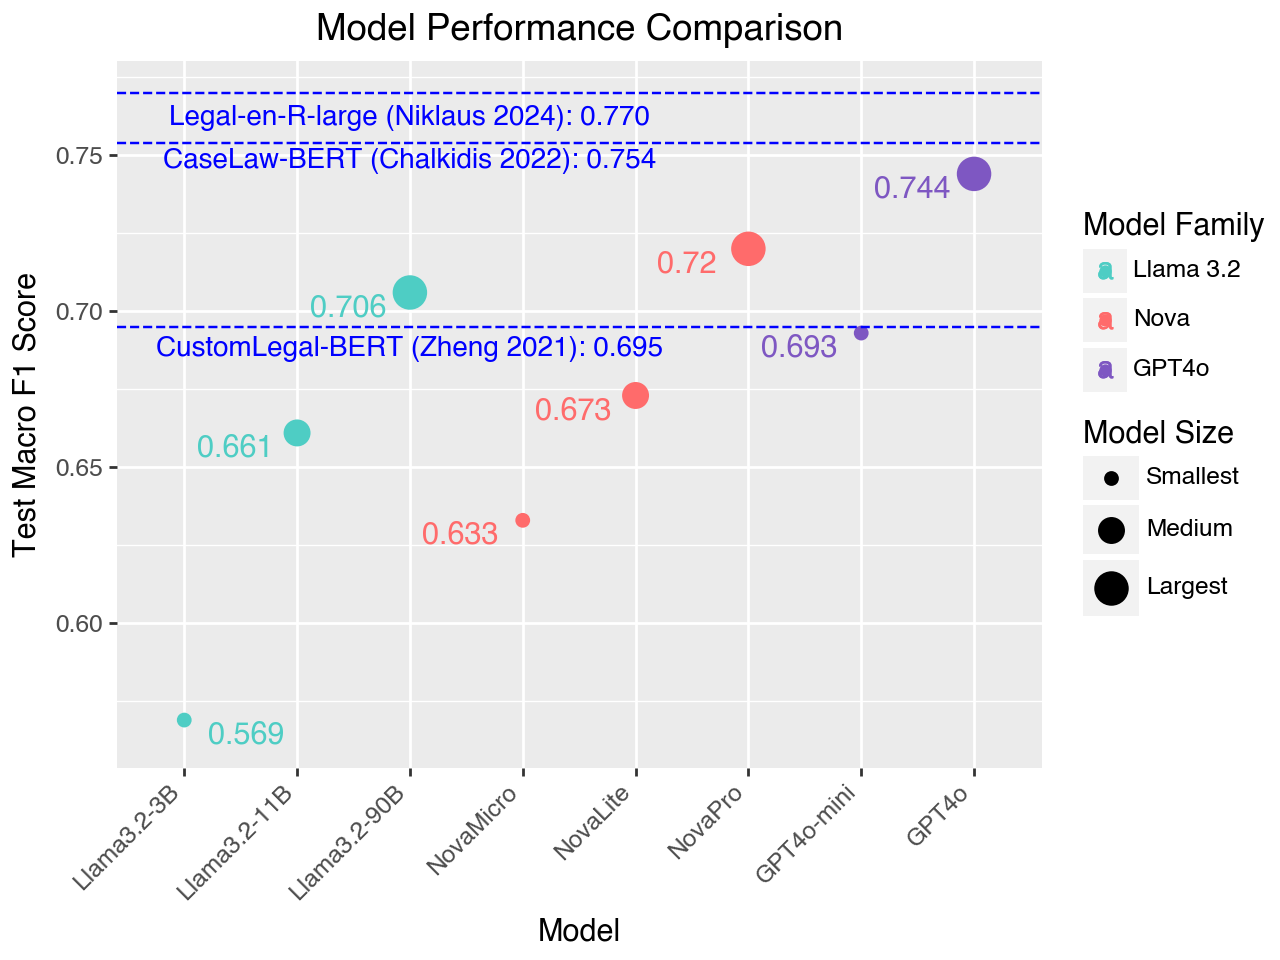

In [24]:
custom_colors = {'Nova': '#FF6B6B', 'Llama 3.2': '#4ECDC4', 'GPT4o': '#7E57C2', 'Published': '#666666'}

ggplot(mapping = aes(x = 'model', y = 'f1_score'), data = results) +\
geom_point(aes(color = 'model_family', label = 'f1_score', size = 'model_size'), data = results[~(results['model'].isin(['Zheng et al 2021','Chalkidis et al 2022', 'Niklaus et al 2024']))]) +\
geom_text(aes(label = 'f1_score', color = 'model_family'), data = results[~(results['model'].isin(['Zheng et al 2021','Chalkidis et al 2022', 'Niklaus et al 2024', 'Llama3.2-3B']))], nudge_y = -0.005, nudge_x = -0.55) +\
geom_text(aes(label = 'f1_score', color = 'model_family'), data = results[(results['model'].isin(['Llama3.2-3B']))], nudge_y = -0.005, nudge_x = 0.55) +\
geom_hline(aes(yintercept = 0.695), linetype = 'dashed', color = 'blue') + annotate("text", x = 'Llama3.2-90B', y = 0.688, label = "CustomLegal-BERT (Zheng 2021): 0.695", color = 'blue', size = 10) +\
geom_hline(aes(yintercept = 0.754), linetype = 'dashed', color = 'blue') + annotate("text", x = 'Llama3.2-90B', y = 0.748, label = "CaseLaw-BERT (Chalkidis 2022): 0.754", color = 'blue', size = 10) +\
geom_hline(aes(yintercept = 0.770), linetype = 'dashed', color = 'blue') + annotate("text", x = 'Llama3.2-90B', y = 0.762, label = "Legal-en-R-large (Niklaus 2024): 0.770", color = 'blue', size = 10) +\
scale_color_manual(values = custom_colors) +\
xlab("Model") + ylab("Test Macro F1 Score") +\
theme(axis_text_x = element_text(angle = 45, hjust = 1)) +\
labs(title = "Model Performance Comparison",
      color = "Model Family",
      size = "Model Size")

In [25]:
all_labels['correct_nova_micro'] = all_labels['label'] ==  all_labels['answer_nova_micro']
all_labels['correct_nova_lite'] = all_labels['label'] ==  all_labels['answer_nova_lite']
all_labels['correct_nova_pro'] = all_labels['label'] ==  all_labels['answer_nova_pro']

all_labels['correct_llama_3b'] = all_labels['label'] ==  all_labels['answer_llama_3b']
all_labels['correct_llama_11b'] = all_labels['label'] ==  all_labels['answer_llama_11b']
all_labels['correct_llama_90b'] = all_labels['label'] ==  all_labels['answer_llama_90b']

all_labels['correct_gpt4o_mini'] = all_labels['label'] ==  all_labels['answer_gpt4o_mini']
all_labels['correct_gpt4o'] = all_labels['label'] ==  all_labels['answer_gpt4o']


### How much do the LLM answers differ?

In [26]:
from sklearn.metrics import pairwise_distances

In [27]:
vars = ['answer_nova_micro', 'answer_nova_lite', 'answer_nova_pro', 'answer_llama_3b', 'answer_llama_11b', 'answer_llama_90b', 'answer_gpt4o_mini', 'answer_gpt4o']

matchrate = pd.DataFrame(1 - pairwise_distances(all_labels[vars].values.T, metric = 'hamming'), columns = vars, index = vars)
matchrate = matchrate.reset_index()

In [28]:
m_matchrate = pd.melt(matchrate, id_vars = 'index')
m_matchrate = m_matchrate.rename(columns = {'index': 'first', 'variable': 'second'})

m_matchrate['first'] = pd.Categorical(m_matchrate['first'], ordered=True, categories = vars)
m_matchrate['second'] = pd.Categorical(m_matchrate['second'], ordered=True, categories = vars)

In [29]:
m_matchrate['MatchRate'] = np.round(100 * m_matchrate['value'], 1)

In [30]:
matchrate

,index,answer_nova_micro,answer_nova_lite,answer_nova_pro,answer_llama_3b,answer_llama_11b,answer_llama_90b,answer_gpt4o_mini,answer_gpt4o
0,answer_nova_micro,1.000000,0.742190,0.730900,0.634550,0.700038,0.728453,0.741250,0.700414
1,answer_nova_lite,0.742190,1.000000,0.770041,0.631916,0.720173,0.752164,0.768160,0.746142
2,answer_nova_pro,0.730900,0.770041,1.000000,0.630975,0.728265,0.795822,0.787354,0.812759
3,answer_llama_3b,0.634550,0.631916,0.630975,1.000000,0.646594,0.627588,0.637561,0.610839
4,answer_llama_11b,0.700038,0.720173,0.728265,0.646594,1.000000,0.728641,0.736545,0.730147
5,answer_llama_90b,0.728453,0.752164,0.795822,0.627588,0.728641,1.000000,0.772864,0.783779
6,answer_gpt4o_mini,0.741250,0.768160,0.787354,0.637561,0.736545,0.772864,1.000000,0.788860
7,answer_gpt4o,0.700414,0.746142,0.812759,0.610839,0.730147,0.783779,0.788860,1.000000


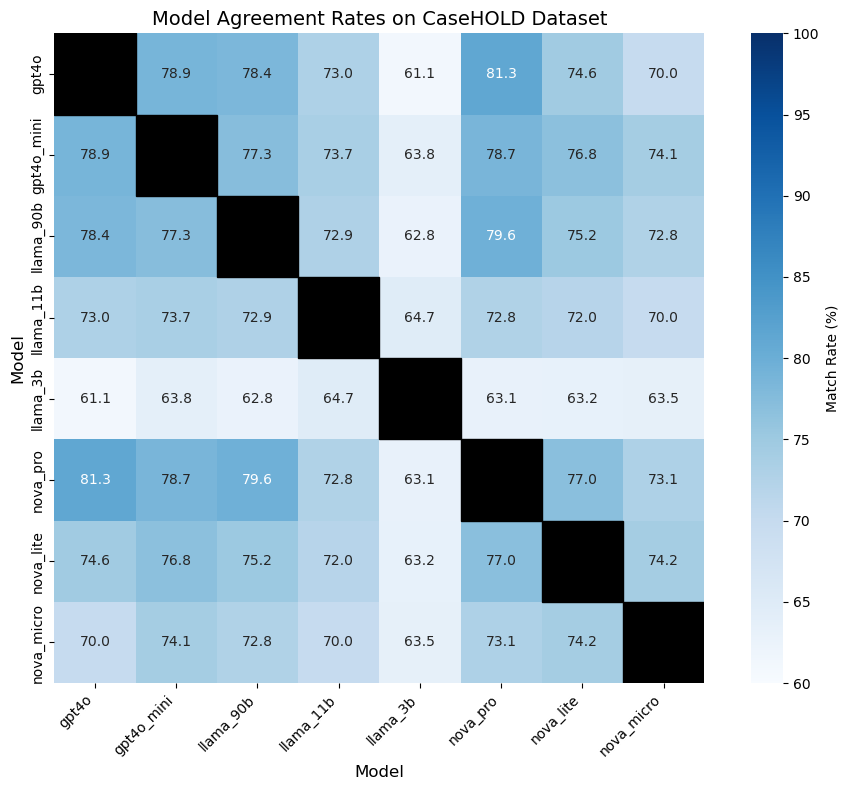

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Clean model names by removing the "answer_" prefix
m_matchrate_clean = m_matchrate.copy()
m_matchrate_clean['first'] = m_matchrate_clean['first'].str.replace('answer_', '')
m_matchrate_clean['second'] = m_matchrate_clean['second'].str.replace('answer_', '')

# Sort models by family and size
model_order = ['gpt4o', 'gpt4o_mini', 'llama_90b', 'llama_11b', 'llama_3b', 'nova_pro', 'nova_lite', 'nova_micro']

# Create pivot table
pivot_data = m_matchrate_clean.pivot(index='first', columns='second', values='MatchRate')
pivot_data = pivot_data.reindex(model_order, axis=0).reindex(model_order, axis=1)

# Create mask for diagonal
mask = np.eye(len(pivot_data), dtype=bool)

# Set up the figure
plt.figure(figsize=(10, 8))

# Create a custom colormap that's easy to read
cmap = sns.color_palette("Blues", as_cmap=True)

# Create the heatmap with improved aesthetics
ax = sns.heatmap(pivot_data, annot=True, fmt=".1f", cmap=cmap, 
                 vmin=60, vmax=100, square=True, mask=mask,
                 cbar_kws={'label': 'Match Rate (%)'})

# Fill diagonal with black
for i in range(len(pivot_data)):
    ax.add_patch(plt.Rectangle((i, i), 1, 1, fill=True, color='black'))

# Add white text labels to diagonal cells
#for i in range(len(pivot_data)):
#    ax.text(i + 0.5, i + 0.5, 'self', color='white', 
#            ha='center', va='center', fontweight='bold')

# Clean up the plot
plt.title("Model Agreement Rates on CaseHOLD Dataset", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Model", fontsize=12)

# Improve label readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Tighten layout
plt.tight_layout()

# Show the plot
plt.show()

### How often do LLMs diverge on a given problem?

In [32]:
vars = ['answer_nova_micro', 'answer_nova_lite', 'answer_nova_pro', 'answer_llama_3b', 'answer_llama_11b', 'answer_llama_90b', 'answer_gpt4o_mini', 'answer_gpt4o']

num_unique_responses = all_labels[vars].T.nunique().to_frame(name = 'num_unique_responses')

In [33]:
num_unique_responses

,num_unique_responses
0,1
1,1
2,2
3,2
4,3
...,...
5309,3
5310,1
5311,3
5312,3


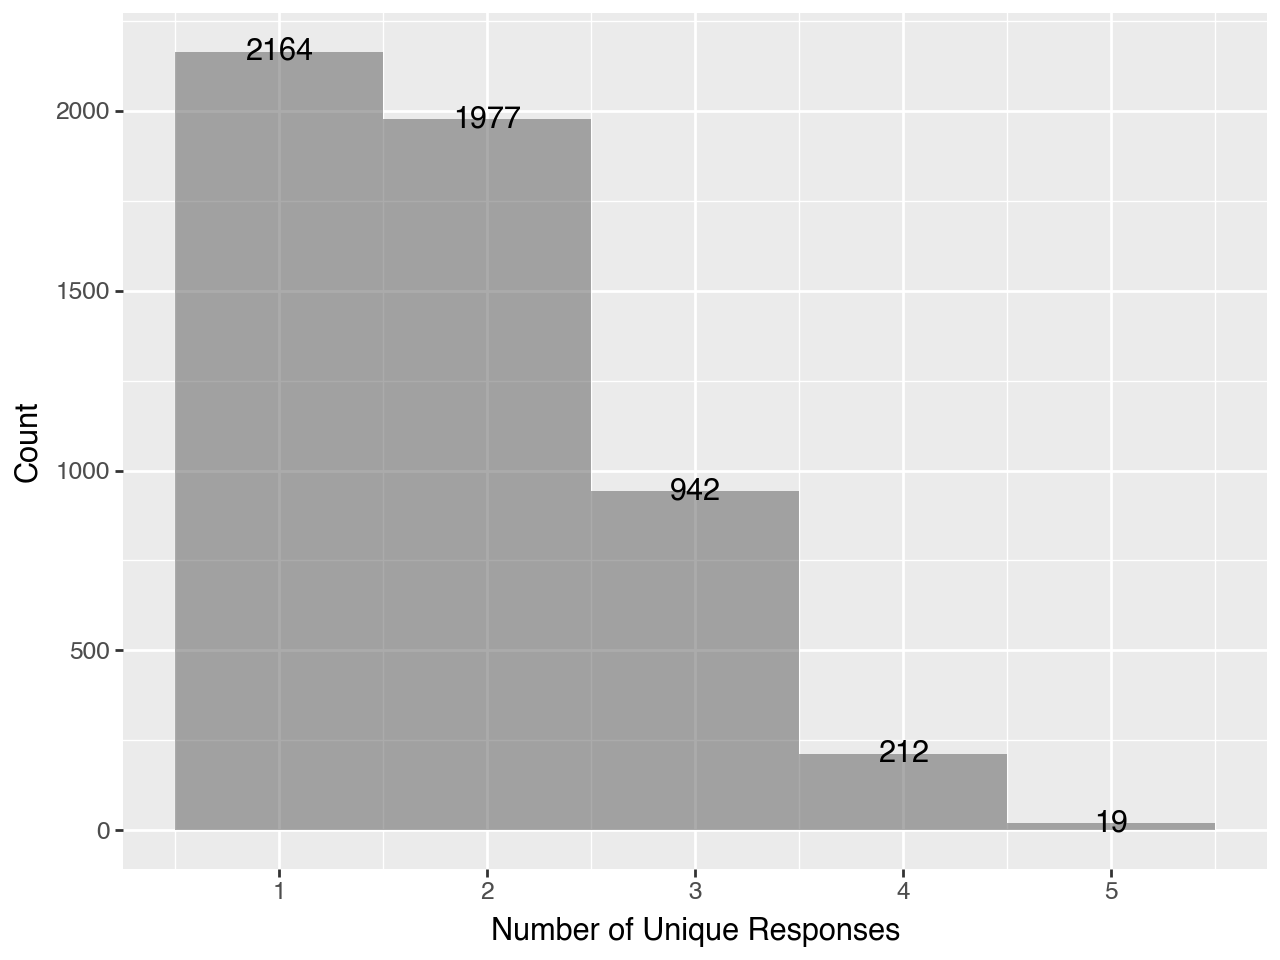

In [34]:
ggplot(mapping = aes(x = 'num_unique_responses'), data = num_unique_responses) + geom_histogram(binwidth = 1, alpha = 0.5) + xlab("Number of Unique Responses") + ylab("Count") +\
stat_count(mapping = aes( label = after_stat('count'))
           , width = 1
           , geom = 'text')

In [35]:
all_labels = pd.concat([all_labels, num_unique_responses], axis = 1)

In [36]:
all_labels.groupby('num_unique_responses')['example_id'].count()

num_unique_responses
1    2164
2    1977
3     942
4     212
5      19
Name: example_id, dtype: int64

In [37]:
full = []

for v in ['correct_nova_micro', 'correct_nova_lite', 'correct_nova_pro', 'correct_llama_3b', 'correct_llama_11b', 'correct_llama_90b', 'correct_gpt4o_mini', 'correct_gpt4o']:
    a = all_labels.groupby('num_unique_responses')[v].agg(['mean', 'count']).reset_index()
    a['model'] = v
    full.append(a)

full = pd.concat(full)
full['model'] = pd.Categorical(full['model'], ordered = True, categories = ['correct_llama_3b', 'correct_llama_11b', 'correct_llama_90b', 'correct_nova_micro', 'correct_nova_lite', 'correct_nova_pro', 'correct_gpt4o_mini', 'correct_gpt4o'])

In [38]:
full.query('num_unique_responses == 1')

,num_unique_responses,mean,count,model
0,1,0.920518,2164,correct_nova_micro
0,1,0.920518,2164,correct_nova_lite
0,1,0.920518,2164,correct_nova_pro
0,1,0.920518,2164,correct_llama_3b
0,1,0.920518,2164,correct_llama_11b
0,1,0.920518,2164,correct_llama_90b
0,1,0.920518,2164,correct_gpt4o_mini
0,1,0.920518,2164,correct_gpt4o


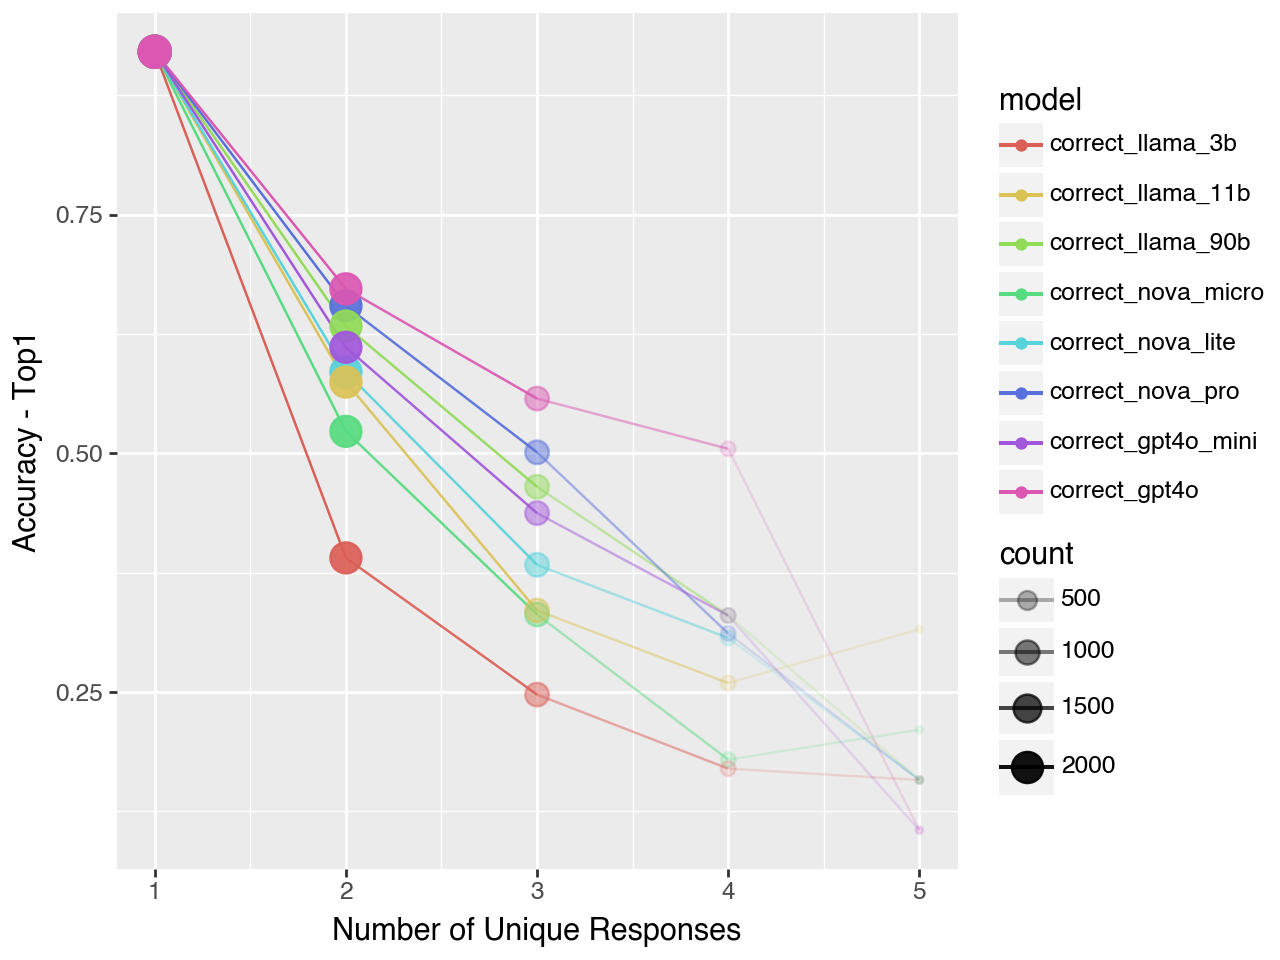

In [39]:
ggplot(mapping = aes(x = 'num_unique_responses', y = 'mean', color = 'model', alpha = 'count'), data = full) + geom_line() + geom_point(aes(size = 'count')) + xlab("Number of Unique Responses") + ylab("Accuracy - Top1") + scale_color_discrete()

In [40]:
vars = ['correct_nova_micro', 'correct_nova_lite', 'correct_nova_pro', 'correct_llama_3b', 'correct_llama_11b', 'correct_llama_90b', 'correct_gpt4o_mini', 'correct_gpt4o']

accuracy_rate = all_labels[vars].mean(axis = 1).to_frame(name = 'accuracy_rate')

In [41]:
accuracy_rate = accuracy_rate.merge(num_unique_responses, left_index=True, right_index=True)

In [42]:
print(accuracy_rate.groupby('num_unique_responses').agg({'accuracy_rate': ['mean', 'count']}).reset_index().to_latex(index = False))

\begin{tabular}{rrr}
\toprule
num_unique_responses & \multicolumn{2}{r}{accuracy_rate} \\
 & mean & count \\
\midrule
1 & 0.920518 & 2164 \\
2 & 0.580551 & 1977 \\
3 & 0.407245 & 942 \\
4 & 0.298939 & 212 \\
5 & 0.171053 & 19 \\
\bottomrule
\end{tabular}



### Anecdotal examples

In [43]:
all_labels.groupby(['correct_llama_90b', 'correct_nova_pro'])['example_id'].count()

correct_llama_90b  correct_nova_pro
False              False               1110
                   True                 449
True               False                377
                   True                3378
Name: example_id, dtype: int64

In [44]:
all_labels.groupby(['correct_nova_micro', 'correct_nova_pro'])['example_id'].count()

correct_nova_micro  correct_nova_pro
False               False               1162
                    True                 772
True                False                325
                    True                3055
Name: example_id, dtype: int64

In [45]:
#Example where everyone agrees
for c in all_labels.columns: 
    print('***{}***'.format(c))
    print(all_labels.iloc[1034][c])

***Unnamed: 0***
1034
***example_id***
48855
***citing_prompt***
and suppressing violations of laws of the United States, “officers may at any time go on board of any vessel subject to the jurisdiction, or to the operation of any law, of the United States, address inquiries to those on board, examine the ship’s documents and papers, and examine, inspect, and search the vessel and use all necessary force to compel compliance.” This statute has been construed to permit the Coast Guard to stop an American vessel in order to conduct “a document and safety inspection on the high seas, even in the absence of a warrant or suspicion of wrongdoing,” United States v. Hilton, 619 F.2d 127, 131 (1st Cir.1980), and to conduct a more intrusive search on the basis of reasonable suspicion, see United States v. Wright-Barker, 784 F.2d 161, 176 (3d Cir.1986) (<HOLDING>), superseded by statute on other grounds as
***holding_0***
holding that forfeiture statute is subject to the fourth amendments prohibit

In [46]:
for c in all_labels.columns: 
    print('***{}***'.format(c))
    print(all_labels.iloc[865][c])

***Unnamed: 0***
865
***example_id***
48686
***citing_prompt***
If the trial discloses that the services were not formally ordered, then the discussion herein concerning constructive ordering of services is applicable. 12 . See United Artists Payphone Corp. v. New York Tel. Co., 8 FCC Rcd 5563 (1993); see also AT & T v. City of New York, 83 F.3d 549 (2d Cir.1996); AT & T Corp. v. Community Health Group, 931 F.Supp. 719 (S.D.Cal.1995); In re Access Charge Reform, 14 FCC Rcd 14221 (1999). 13 . See also City of New York, 83 F.3d at 553 (relying on United Artists to hold that a party can become a " ‘customer,’ in one of two ways: (1) by affirmatively ordering the service ... or (2) by constructively ordering [service] and creating an 'inadvertent carrier-customer relationship ....' ”). 14 . See US Wats, Inc. v. AT & T Co., 1994 WL 116009, at *5 (<HOLDING>). 15 . While not directly stating so, AT & T
***holding_0***
holding that filedrate doctrine does not apply when adjudication of the pla